In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/My Drive/CECS551_Fianl_Project_Dataset/

/content/drive/My Drive/CECS551_Fianl_Project_Dataset


In [ ]:
import pandas as pd
import chardet
import seaborn as sns
import numpy as np
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 

import warnings
warnings.filterwarnings("ignore")

stores = pd.read_csv("CECS551_dataset_01/stores.csv")
test = pd.read_csv("CECS551_dataset_01/test.csv")
data = pd.read_csv("CECS551_dataset_01/train.csv")

train = data

store_01 = pd.read_csv("CECS551_dataset_01/store_features/store_01.xlsx")
store_02 = pd.read_excel("CECS551_dataset_01/store_features/store_02.xlsx")
store_03 = pd.read_excel("CECS551_dataset_01/store_features/store_03.xlsx")
store_04 = pd.read_excel("CECS551_dataset_01/store_features/store_04.xlsx")
store_05 = pd.read_excel("CECS551_dataset_01/store_features/store_05.xlsx")
store_06 = pd.read_excel("CECS551_dataset_01/store_features/store_06.xlsx")
store_07 = pd.read_excel("CECS551_dataset_01/store_features/store_07.xlsx")
store_08 = pd.read_excel("CECS551_dataset_01/store_features/store_08.xlsx")
store_09 = pd.read_excel("CECS551_dataset_01/store_features/store_09.xlsx")
store_10 = pd.read_excel("CECS551_dataset_01/store_features/store_10.xlsx")

store_11_35 = pd.read_excel("CECS551_dataset_01/store_features/store_11_35.xlsx")
ind_stores = [store_01,store_02,store_03,store_04,store_05,store_06,store_07,store_08,store_09,store_10]
features = pd.concat(ind_stores)


# This section merges dataframes from stores.csv, train.csv and features.csv

In [ ]:
# Fetch data from 1-10 stores for training model
store_1_10_train = data.loc[data['Store'] <= 10].copy()
#print(store_1_10_train.tail(10))

# Merge store 1-10 data with stores
store_1_10_stores_data = pd.merge(store_1_10_train,stores,on='Store',how='left')
#store_1_10_stores_data['Date'] = pd.to_datetime(store_1_10_stores_data['Date'])

# Merge Features with train and stores.csv
store_1_10_stores_data = pd.merge(store_1_10_stores_data,features,on=['Store','Date'],how='left')
store_1_10_stores_data.sort_values(by=['Date'],inplace=True)
store_1_10_stores_data.set_index(store_1_10_stores_data.Date, inplace=True)
store_1_10_stores_data['IsHoliday_x'].isin(store_1_10_stores_data['IsHoliday_y']).all()
store_1_10_stores_data['Date'] = pd.to_datetime(store_1_10_stores_data['Date'])


# Fetch data from 11-35 stores for testing model
store_11_to_35 = data.loc[data['Store'] > 10].copy()
store_11_to_35 = store_11_to_35.loc[store_11_to_35['Store'] < 36].copy()

# Merge store 11-35 data with stores
store_11_35_stores_data = pd.merge(store_11_to_35,stores,on='Store',how='left')

# Merge Features with train and stores.csv for store 11 to 35
store_11_35_stores_data = pd.merge(store_11_35_stores_data,features,on=['Store','Date'],how='left')
store_11_35_stores_data.sort_values(by=['Date'],inplace=True)
store_11_35_stores_data.set_index(store_11_35_stores_data.Date, inplace=True)
store_11_35_stores_data['IsHoliday_x'].isin(store_11_35_stores_data['IsHoliday_y']).all()
store_11_35_stores_data['Date'] = pd.to_datetime(store_11_35_stores_data['Date'])

trainDf = store_1_10_stores_data.copy()
testDf = store_11_35_stores_data.copy()

data = pd.merge(data,stores,on='Store',how='left')
data['Date'] = pd.to_datetime(data['Date'])
features['Date'] = pd.to_datetime(features['Date'])

data = pd.merge(data,features,on=['Store','Date'],how='left')

data['Date'] = pd.to_datetime(data['Date'])
data.sort_values(by=['Date'],inplace=True)
data.set_index(data.Date, inplace=True)
data['IsHoliday_x'].isin(data['IsHoliday_y']).all()


Store                         0
Dept                          0
Date                          0
Weekly_Sales                  0
IsHoliday_x                   0
Type                          0
Size                          0
IsHoliday_y              323731
Temperature              323731
gas_price                323731
discount_promotional     380978
discount_clearance       390193
discount_damaged_good    384193
discount_competitive     381578
CPI                      324649
Unemployment             324649
dtype: int64

In [ ]:
# Handling missing values
def preProcessingData(data):
  data["CPI"].fillna(features["CPI"].median(),inplace=True)
  data["Unemployment"].fillna(features["Unemployment"].median(),inplace=True)
  data["discount_promotional"].fillna(value=0,inplace=True)
  data["discount_clearance"].fillna(value=0,inplace=True)
  data["discount_damaged_good"].fillna(value=0,inplace=True)
  data["discount_competitive"].fillna(value=0,inplace=True)
  data["Temperature"].fillna(features["Temperature"].median(),inplace=True)
  data["gas_price"].fillna(features["gas_price"].median(),inplace=True)
  data.isnull().sum()

  #del data['gas_price']

  # After Merging IsHoliday value changes to IsHoliday, change it back to IsHoliday
  data.drop(columns='IsHoliday_y', axis=1,inplace=True)
  data.rename(columns={"IsHoliday_x" : "IsHoliday"}, inplace=True)
  data.isnull().sum()
  return data

data = preProcessingData(data)

trainDf = preProcessingData(trainDf)
testDf = preProcessingData(testDf)



# Preprocessing of data, handling missing values, NaN values

In [ ]:
def splitData(data):
  # Split the date into days, month and year
  data['Year'] = data['Date'].dt.year
  data['Month'] = data['Date'].dt.month
  data['Week'] = data['Date'].dt.week

  # Calculate max, min, median and std deviation of first 10 store
  agg_data = data.groupby(['Store', 'Dept']).Weekly_Sales.agg(['max', 'min', 'mean', 'median', 'std']).reset_index()
  agg_data.isnull().sum()
  data.head(10)

  # Merge the above dataframe with the mainData frame
  store_data = pd.merge(left=data,right=agg_data,on=['Store', 'Dept'],how ='left')
  #store_data.dropna(inplace=True)
  data = store_data.copy()
  del store_data

  # Sort the dataframe by the date 
  data['Date'] = pd.to_datetime(data['Date'])
  data.sort_values(by=['Date'],inplace=True)
  data.set_index(data.Date, inplace=True)
  #data.info()

  data['Total_discount'] = data['discount_promotional']+data['discount_clearance']+data['discount_damaged_good']+data['discount_competitive']
  data.drop(['discount_promotional','discount_clearance','discount_damaged_good','discount_competitive'], axis = 1,inplace=True)
  return data

data = splitData(data)
trainDf = splitData(trainDf)
testDf = splitData(testDf)

arimaData = data.copy()


            Store  Dept       Date  Weekly_Sales  IsHoliday Type    Size  \
Date                                                                       
2010-02-05      1     1 2010-02-05      24924.50      False    A  151315   
2010-02-05      9    97 2010-02-05        668.48      False    B  125833   
2010-02-05      9    85 2010-02-05        693.87      False    B  125833   
2010-02-05      8    80 2010-02-05       8654.60      False    A  155078   
2010-02-05      9    55 2010-02-05      11123.56      False    B  125833   
...           ...   ...        ...           ...        ...  ...     ...   
2012-10-26      2    26 2012-10-26       9258.88      False    A  202307   
2012-10-26     38    23 2012-10-26         53.12      False    C   39690   
2012-10-26     27     6 2012-10-26       5339.65      False    A  204184   
2012-10-26     36    40 2012-10-26      10216.27      False    A   39910   
2012-10-26     45    98 2012-10-26       1076.80      False    B  118221   

           

# Draw a scatter plot displaying the relation between different features with weekly sales

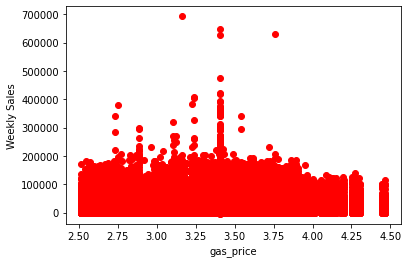

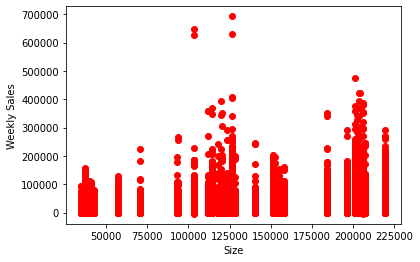

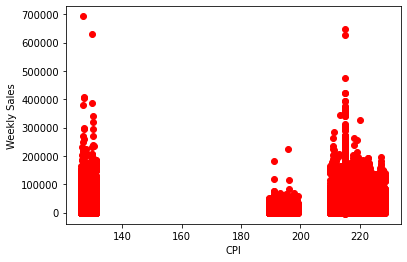

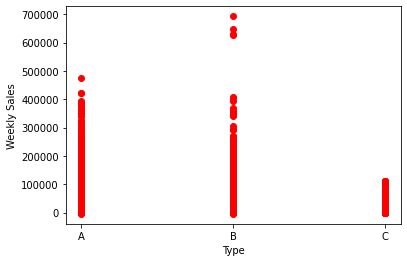

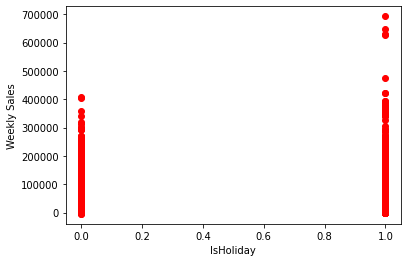

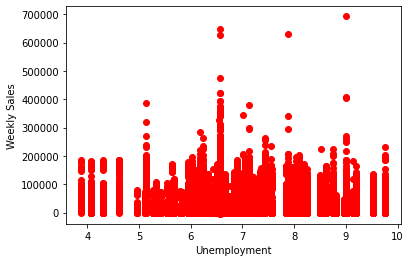

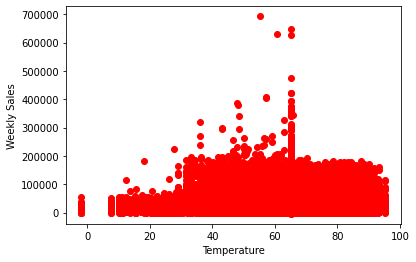

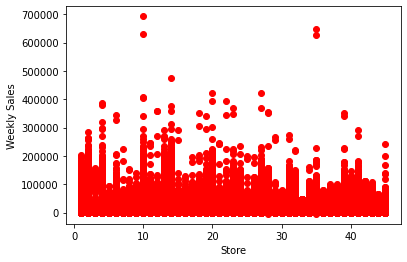

In [ ]:
# Check weekly sales with other features
def scatter(dataset, column):
    plt.figure()
    plt.scatter(data[column] , data['Weekly_Sales'], color = 'red')
    plt.ylabel('Weekly Sales')
    plt.xlabel(column)

scatter(data, 'gas_price')
scatter(data, 'Size')
scatter(data, 'CPI')
scatter(data, 'Type')
scatter(data, 'IsHoliday')
scatter(data, 'Unemployment')
scatter(data, 'Temperature')
scatter(data, 'Store')


In [ ]:
def gatherNumericData(data):
  #numeric_col = ['Weekly_Sales','Size','Temperature','gas_price','CPI','Unemployment','Total_discount']
  numeric_col = ['Weekly_Sales','Size','Temperature','Unemployment','CPI','Total_discount']

  data_numeric = data[numeric_col].copy()

  # Remove negative weekly sales and have only positive sales in the dataframe
  y = data["Weekly_Sales"][data.Weekly_Sales < 0]
  data=data[data['Weekly_Sales']>=0]
  # Convert IsHoliday column to 0 and 1, so that it fits into the model
  data['IsHoliday'] = data['IsHoliday'].astype('str').map({'True':0,'False':1})

  return data

data = gatherNumericData(data)

trainDf = gatherNumericData(trainDf)
testDf = gatherNumericData(testDf)


# Perform One hot encoding on columns like type, store and dept

In [ ]:
def oneHotEncoding(data):
  # One hot encoding
  cat_col = ['Store','Dept','Type']
  data_cat = data[cat_col].copy()

  data_cat.tail()
  data_cat = pd.get_dummies(data_cat,columns=cat_col)
  data = pd.concat([data, data_cat],axis=1)
  data.drop(columns=cat_col,inplace=True)
  data.drop(columns=['Date'],inplace=True)

  return data

data = oneHotEncoding(data)
trainDf = oneHotEncoding(trainDf)
testDf = oneHotEncoding(testDf)



# Data normalisation using MinMax Scaler

In [ ]:
# Data Normalisation
num_col = ['Weekly_Sales','Size','Temperature','gas_price','CPI','Unemployment','Total_discount','max','min','mean','median','std']
#num_col = ['Weekly_Sales','Size','Temperature','Unemployment','CPI','Total_discount','max','min','mean','median','std']

from sklearn.preprocessing import MinMaxScaler
minmax_scale = MinMaxScaler(feature_range=(0, 1))

def normalization(df,col):
  for i in col:
    arr = df[i]
    arr = np.array(arr)
    df[i] = minmax_scale.fit_transform(arr.reshape(len(arr),1))
  return df

data = normalization(data.copy(),num_col)

trainDf = normalization(trainDf.copy(),num_col)
testDf = normalization(testDf.copy(),num_col)



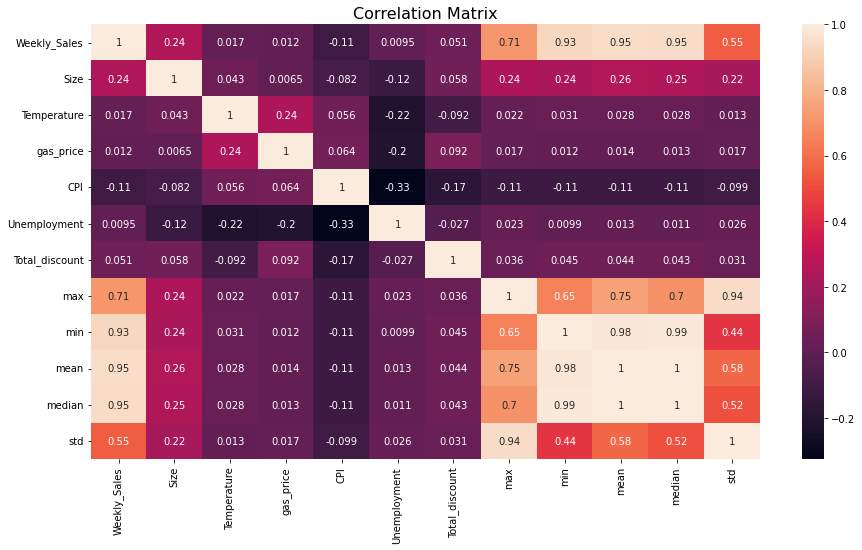

In [ ]:
# Correlation between features of dataset#
def plotFigure(data):
  plt.figure(figsize=(15,8))
  corr = data[num_col].corr()
  sns.heatmap(corr,vmax=1.0,annot=True)
  plt.title('Correlation Matrix',fontsize=16)
  plt.show()
  data.fillna(value=0,inplace=True)

  return data

data = plotFigure(data)


# Using Random regressor to model the data and create a feature rank for the columns in dataframe

In [ ]:
def randomRegressor(data):
  # Using Random forest regressor to rank the feature corelation from the dataset
  feature_col = data.columns.difference(['Weekly_Sales'])
  from sklearn.ensemble import RandomForestRegressor
  radm_clf = RandomForestRegressor(oob_score=True,n_estimators=23)
  radm_clf.fit(data[feature_col], data['Weekly_Sales'])

  return radm_clf, data

radm_clf, data = randomRegressor(data)
saveModel = radm_clf
feature_col = data.columns.difference(['Weekly_Sales'])

trainDf.fillna(value=0,inplace=True)
radm_clf_train, trainDf = randomRegressor(trainDf)
testDf.fillna(value=0,inplace=True)
radm_clf_test, testDf = randomRegressor(testDf)

feature_col_train = trainDf.columns.difference(['Weekly_Sales'])
feature_col_test = testDf.columns.difference(['Weekly_Sales'])



In [ ]:
def createFeatureRank(feature_col, radm_clf, data):
  indices = np.argsort(radm_clf.feature_importances_)[::-1]
  feature_rank = pd.DataFrame(columns = ['rank', 'feature', 'importance'])

  for f in range(data[feature_col].shape[1]):
      feature_rank.loc[f] = [f+1,
                            data[feature_col].columns[indices[f]],
                            radm_clf.feature_importances_[indices[f]]]

  return feature_rank


feature_rank_train = createFeatureRank(feature_col_train, radm_clf_train, trainDf)
feature_rank_test = createFeatureRank(feature_col_test, radm_clf_test, testDf)
feature_rank = createFeatureRank(feature_col, radm_clf, data)

print('Feature random\n')
print(feature_rank)

Feature random

    rank  feature    importance
0      1     mean  8.806413e-01
1      2     Week  3.308051e-02
2      3   median  2.696307e-02
3      4      max  1.532887e-02
4      5    Month  7.067202e-03
..   ...      ...           ...
139  140  Dept_45  1.828599e-10
140  141  Dept_51  1.518145e-10
141  142  Dept_78  3.642326e-12
142  143  Dept_39  1.876052e-13
143  144  Dept_43  8.613539e-16

[144 rows x 3 columns]


In [ ]:
#X = data[x]
#Y = data['Weekly_Sales']

In [ ]:
#data = pd.concat([X,Y],axis=1)
#X = data.drop(['Weekly_Sales'],axis=1)
#Y = data.Weekly_Sales


# Creating linear regression, Random forest regressor, ridge regression and XGBoost regression

In [ ]:
from sklearn.linear_model import LinearRegression

def linearRegressionTrain(X_train, X_test, Y_train, Y_test, lr):
  ##print(X_train.head(10))
  #print(Y_train.head(10))
  lr.fit(X_train, Y_train)
  lr_acc = lr.score(X_test,Y_test) * 100
  print("Linear Regressor Accuracy - ",lr_acc)

#lr = LinearRegression(normalize=False)
#linearRegressionTrain(X_train, X_test, y_train, y_test, lr)

In [ ]:
def selectFeatures(feature_rank, data):
  # Selecting the relevant feature and building the model using the same

  x=feature_rank.loc[0:22,['feature']]
  x=x['feature'].tolist()

  X = data[x]
  Y = data['Weekly_Sales']

  data = pd.concat([X,Y],axis=1)
  X = data.drop(['Weekly_Sales'],axis=1)
  Y = data.Weekly_Sales
  

  return X, Y

lr = LinearRegression(normalize=False)
# Build a training dataset and testing dataset
print("Full dataset linear regression random split \n") 
X, Y = selectFeatures(feature_rank, data)
X_train_random,X_test_random,y_train_random,y_test_random = train_test_split(X,Y,test_size=0.70, random_state=50)
linearRegressionTrain(X_train_random, X_test_random, y_train_random, y_test_random, lr)

print("Split data set for 1-10 store linear regression. \n")
print("Check the model accuracy for store 1-10 \n")
X, Y = selectFeatures(feature_rank_train, trainDf)
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.20, random_state=50)
linearRegressionTrain(X_train, X_test, y_train, y_test, lr)

print("Split data set for 11-35 store linear regression \n")
X, Y = selectFeatures(feature_rank_test, testDf)
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.70, random_state=50)
linearRegressionTrain(X_train, X_test, y_train, y_test, lr)


Full dataset linear regression random split 

Linear Regressor Accuracy -  91.0987273529285
Split data set for 1-10 store linear regression. 

Check the model accuracy for store 1-10 

Linear Regressor Accuracy -  91.99814208981245
Split data set for 11-35 store linear regression 

Linear Regressor Accuracy -  89.38175936658561


Text(0.5, 1.0, 'Predicted vs Actual Sales using Linear regression for split of 80/20')

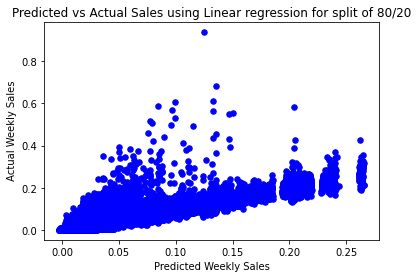

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict

predictions = cross_val_predict(lr, X_test_random, y_test_random, cv=10)
plt.scatter(predictions, y_test_random, s=30, color = 'blue', zorder=10)
plt.xlabel('Predicted Weekly Sales')
plt.ylabel(' Actual Weekly Sales')
plt.title('Predicted vs Actual Sales using Linear regression for split of 80/20')


In [ ]:
predictions1 = cross_val_predict(lr, X_test, y_test, cv=10)
plt.scatter(predictions1, y_test, s=30, color = 'black', zorder=10)
plt.xlabel('Predicted Weekly Sales')
plt.ylabel(' Actual Weekly Sales')
plt.title('Predicted vs Actual Sales using Linear regression for store 11-35')

In [ ]:
# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

def randomRegressorModel(X_train,X_test,y_train,y_test):
  rf = RandomForestRegressor()
  rf.fit(X_train, y_train)

  rf_acc = rf.score(X_test,y_test)*100
  print("Random Forest Regressor Accuracy - \n",rf_acc)

  y_pred = rf.predict(X_test)
  
print("Random forest regression using random 80/20 split")
randomRegressorModel(X_train_random,X_test_random,y_train_random,y_test_random)
print("Random forest regression for store 11-35")
randomRegressorModel(X_train,X_test,y_train,y_test)

In [ ]:
from xgboost import XGBRegressor
def xGBoostModel(X_train,X_test,y_train,y_test):
  xgbr = XGBRegressor()
  xgbr.fit(X_train, y_train)

  xgb_acc = xgbr.score(X_test,y_test)*100
  print("XGBoost Regressor Accuracy - ",xgb_acc)

  y_pred = xgbr.predict(X_test)

print("xGBoost regression for store 11-35 \n")
xGBoostModel(X_train,X_test,y_train,y_test)

print("xGBoost regression using random 80/20 split \n")
xGBoostModel(X_train_random,X_test_random,y_train_random,y_test_random)

In [ ]:
from sklearn.linear_model import Ridge

def ridgeRegressionModel(X_train,X_test,y_train,y_test):
  model = Ridge()
  model.fit(X_train, y_train)

  model.fit(X_train,y_train)

  #train and test scorefor ridge regression
  train_score_ridge = model.score(X_train, y_train)
  test_score_ridge = model.score(X_test, y_test)

  print("The train score for ridge model is {}".format(train_score_ridge))
  print("The test score for ridge model is {}".format(test_score_ridge))

print("Ridge regression for store 11-35 \n")
ridgeRegressionModel(X_train,X_test,y_train,y_test)
print("Ridge regression using random 80/20 split \n")
ridgeRegressionModel(X_train_random,X_test_random,y_train_random,y_test_random)